## Settings for Google Colab

Please uncomment and run cell below if your are on Colab to set data and auxiliary files.

In [1]:
#!pip install pytorch-lightning
#!pip install torchinfo
#!pip install torch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 --index-url https://download.pytorch.org/whl/cu124
#!pip install pandas seaborn matplotlib scikit-learn


Looking in indexes: https://download.pytorch.org/whl/cu124
     ---------------------------------------- 0.0/2.5 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.5 GB 49.1 MB/s eta 0:00:51
     ---------------------------------------- 0.0/2.5 GB 44.6 MB/s eta 0:00:56
     ---------------------------------------- 0.0/2.5 GB 46.9 MB/s eta 0:00:53
      --------------------------------------- 0.0/2.5 GB 45.9 MB/s eta 0:00:54
      --------------------------------------- 0.0/2.5 GB 43.3 MB/s eta 0:00:57
      --------------------------------------- 0.1/2.5 GB 43.6 MB/s eta 0:00:57
      --------------------------------------- 0.1/2.5 GB 42.2 MB/s eta 0:00:59
     - -------------------------------------- 0.1/2.5 GB 44.4 MB/s eta 0:00:55
     - -------------------------------------- 0.1/2.5 GB 44.9 MB/s eta 0:00:55
     - -------------------------------------- 0.1/2.5 GB 45.2 MB/s eta 0:00:54
     - -------------------------------------- 0.1/2.5 GB 46.0 MB/s eta 0:00:53
 

## DeepAnt

In [ ]:
import pandas as pd
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from torchinfo import summary
import torch.nn as nn
import numpy as np
import pytorch_lightning as pl
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from utils import plot_predictions, loss_plot, ts_plot
from torch import optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pl.seed_everything(42, workers=True)


if not torch.cuda.is_available():
    print('Please Activate GPU Accelerator if available')
else:
    print('Everything is Set')


Seed set to 42


Everything is Set


In [41]:
class DeepAnt(nn.Module):
    def __init__(self, input_dim, output_dim, conv_channels, kernel_size, pool_size, dense_units,lookback_window, dropout_prob=0.25):
        super().__init__()

        # First convolutional block
        self.convblock1 = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=conv_channels, kernel_size=kernel_size, padding='valid'),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=pool_size)
        )
        
        # Second convolutional block
        self.convblock2 = nn.Sequential(
            nn.Conv1d(in_channels=conv_channels, out_channels=conv_channels, kernel_size=kernel_size, padding='valid'),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=pool_size)
        )
        
        dummy_input = torch.zeros(1, input_dim, lookback_window)  # Example input with lookback window = 20
        dummy_output = self.convblock2(self.convblock1(dummy_input))
        flattened_size = dummy_output.numel()

        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Fully connected block
        self.denseblock = nn.Sequential(
            nn.Linear(flattened_size, dense_units),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_prob),
        )
        
        # Output layer
        self.out = nn.Linear(dense_units, output_dim)
        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.flatten(x)
        x = self.denseblock(x)
        x = self.out(x)
        return x

def preprocess_data(data, lookback_window, prediction_window):
    """
    Preprocess data for DeepAnT.
    
    Args:
        data (numpy.ndarray): Original time series data of shape (timesteps, channels).
        lookback_window (int): Number of timesteps to use as input.
        prediction_window (int): Number of timesteps to predict.
        batch_size (int): Number of samples per batch.
        
    Returns:
        X_batches (numpy.ndarray): Input data of shape (num_batches, batch_size, channels, lookback_window).
        y_batches (numpy.ndarray): Target data of shape (num_batches, batch_size, prediction_window).
    """
    # Ensure data is a NumPy array
    data = np.array(data)

    # Split input and target channels
    input_data = data[:, :]  # All channels
    target_data = data[:, -1:]  # last channel (reshape to 2D for scaling)
    
    # Normalize input and target data separately
    input_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()
    
    input_data_scaled = input_scaler.fit_transform(input_data)
    target_data_scaled = target_scaler.fit_transform(target_data)

    # Create input-target pairs using sliding window
    X, y = [], []
    for i in range(len(data) - lookback_window - prediction_window + 1):
        X.append(input_data_scaled[i:i + lookback_window].T)  # Transpose to get (channels, lookback_window)
        y.append(target_data_scaled[i + lookback_window:i + lookback_window + prediction_window, 0])  # Only the target

    X = np.array(X)
    y = np.array(y)

    # Reshape into batches
    #num_batches = len(X) // batch_size
    #X_batches = X[:num_batches * batch_size].reshape(num_batches, batch_size, X.shape[1], X.shape[2])
    #y_batches = y[:num_batches * batch_size].reshape(num_batches, batch_size, y.shape[1])

    return X, y, input_scaler, target_scaler

## Data Import

In order to implement DeepAnt I will use a dataset that is part of Numenta Benchmark that is used in the Paper as part of Model Validation. The dataset can be found in the same Repo. According to the name, the dataset contains Traveltime as a timeseries. 

The task is to find out what scores are anomaly.

(2099, 6)

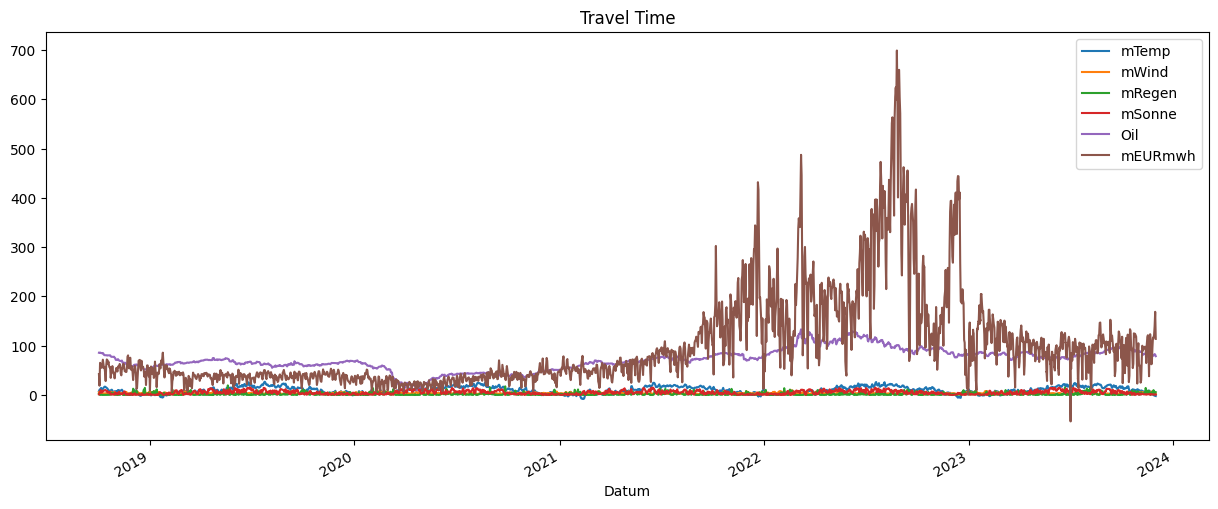

In [42]:
df = pd.read_csv('e_data.csv', index_col = 'Datum', parse_dates=['Datum'])
df = df.drop(columns=['Unnamed: 0','previousDayE'])
df.plot(figsize = (15, 6), title = 'Travel Time', legend = True)
df.shape

### Preparing the dataset(s) and the Model

In [ ]:

lookback_window = 14
prediction_window = 3
#batch_size = 32
output_dim = prediction_window
conv_channels = 32
kernel_size = 4
pool_size = 2
dense_units = 40
num_epochs = 15 


X, y, input_scaler, target_scaler = preprocess_data(df,lookback_window,prediction_window)

#X = X_batches.reshape(-1, X_batches.shape[2], X_batches.shape[3])  # Shape: (total_samples, channels, lookback_window)
#y = Y_batches.reshape(-1, y_batches.shape[2])  # Shape: (total_samples, prediction_window)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
# Convert back to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
#X_train.shape
channel = X_train.shape[1]
model = DeepAnt(channel,output_dim,conv_channels,kernel_size,pool_size,dense_units,lookback_window).to(device)

(1978, 6, 14)

### Training

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)
# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0.0
    model.train()  # Set model to training mode
    
    for batch_idx in range(X_train_tensor.size(0)):  # Iterate over batches
        inputs = X_train_tensor # Shape: (batch_size, channels, lookback_window)
        targets = y_train_tensor  # Shape: (batch_size, prediction_window)
        
        # Zero the gradient buffers
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Average loss for the epoch
    avg_loss = epoch_loss / X_train_tensor.size(0)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training complete!")


Epoch [1/15], Loss: 0.0025
Epoch [2/15], Loss: 0.0012
Epoch [3/15], Loss: 0.0011
Epoch [4/15], Loss: 0.0010
Epoch [5/15], Loss: 0.0010
Epoch [6/15], Loss: 0.0010
Epoch [7/15], Loss: 0.0009
Epoch [8/15], Loss: 0.0009
Epoch [9/15], Loss: 0.0009
Epoch [10/15], Loss: 0.0009
Epoch [11/15], Loss: 0.0009
Epoch [12/15], Loss: 0.0009
Epoch [13/15], Loss: 0.0009
Epoch [14/15], Loss: 0.0008
Epoch [15/15], Loss: 0.0008
Training complete!


### Testing

In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = []
    for i in range(X_test_tensor.size(0)):
        outputs = model(X_test_tensor[i:i+1].to(device))
        y_pred.append(outputs.cpu().numpy())
    y_pred = np.array(y_pred).squeeze()  # Shape: (num_samples, prediction_window)

y_pred_rescaled = target_scaler.inverse_transform(y_pred)  # Rescale predictions
y_true_rescaled = target_scaler.inverse_transform(y_test)  # Rescale targets

targets = pd.DataFrame(y_true_rescaled)
results = pd.DataFrame(y_pred_rescaled)

### For Day z

Evaluation Metrics:
MSE: 1805.3313
MAE: 26.4648
R²: 0.6879


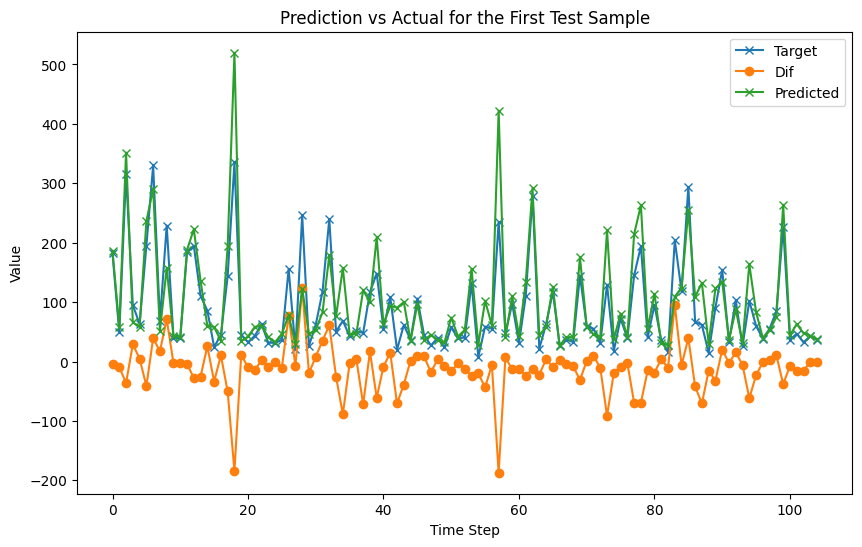

In [92]:
# Calculate evaluation metrics
z = 0
mse = mean_squared_error(targets[z], results[z])
mae = mean_absolute_error(targets[z], results[z])
r2 = r2_score(targets[z], results[z])

print(f"Evaluation Metrics:\nMSE: {mse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}")

# Plot predictions vs actual values for the first sample in the test set
plt.figure(figsize=(10, 6))
plt.plot(targets[z], label="Target", marker='x')
plt.plot(targets[z]-results[z], label="Dif", marker='o')
plt.plot(results[z], label="Predicted", marker='x')
plt.title("Prediction vs Actual for the First Test Sample")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()